# Programming Exercise 2: Logistic Regression with regularization

Regularized Logistic regression is a classification algorithm 

In [39]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
 

Number of samples 118
Number of parameters:  2
y shape (118,)


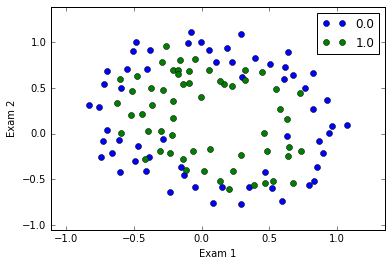

In [59]:
data = np.loadtxt('ex2data2.txt', delimiter=',')

X = data[:,0:2]
y = data[:,2]  # differs from y = data[:, 2:3]
m,n = X.shape
print('Number of samples', m)
print('Number of parameters: ', n)
print('y shape', y.shape)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
groups = df.groupby(y)
plt.margins(0.15)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)

plt.xlabel('Exam 1')
plt.ylabel('Exam 2')
plt.legend()
plt.show()


## try solution directly from scikit learn

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

#lr = LogisticRegression() # default solver to 'liblinear"

# lbfgs seems to be Same as mine
lr = LogisticRegression(solver='lbfgs', C=0.99)  # C = 1/lambda (default = 1, if lower, regularization is stronger)
#lr = LogisticRegression(solver='sag', max_iter = 1000000000)  # ???
#lr = LogisticRegression(solver='newton-cg', max_iter = 1000000000)  # seems quite the same as lbfgs

lr.fit(X_train,y_train)
lr.get_params()

print('Coeff = {}, intercept = {}'.format(lr.coef_, lr.intercept_ ))

print('Score on training set : ', lr.score(X_train,y_train))
print('Score on test set : ', lr.score(X_test,y_test))


X_small_test = [
    [0,0],
    [-0.25,0.25],
    [0.2,0.5],
    [1,-1],
    [1,1],
    [-0.25, 1.5],  # expected as human : 1 1 1 0 0 0  
    [0,1],
    [0,-1]]
print('Predict on small test : ', lr.predict(X_small_test))


Coeff = [[-0.3938763  -0.09820137]], intercept = [-0.03047309]
Score on training set :  0.508928571429
Score on test set :  0.0
Predict on small test :  [ 0.  1.  0.  0.  0.  0.  0.  1.]


Explanation for the equation :
$z=w_{0} + w_{1}x_{1} + w_{2}x_{2}$

Here, $x{_2}$ is on y axis, so we can define the equation as follows:
$x_{2} = \frac{w_{0}}{w_{2}} - \frac{w_{1}}{w_{2}}x_{1}$

Obivously, this is not enough, simply because trying to define a linear boundary is not adapted to this problem

Predict on small test :  [ 0.  1.  1.  0.  0.  0.  1.]
[-0.03047309 -0.3938763  -0.09820137]


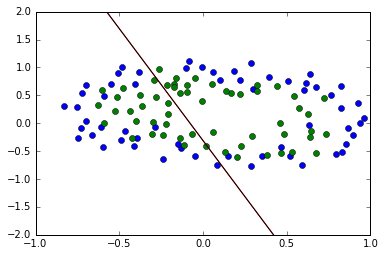

In [66]:
def plotDecisionBoundary(theta, X):
    # draw the line according to theta parameters
    plot_x = [min(X[:,1])-1, max(X[:,1]+1)]
    #print('plot_x:',plot_x)

    plot_y = (-1/theta[2]) * (np.multiply(theta[1],plot_x) + theta[0])
    #print('plot_y:',plot_y)

    plt.plot(plot_x, plot_y)

    #plt.show()
    
def plotDecisionBoundary2(lr):
    w = lr.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-1, 1)
    yy = a * xx - (lr.intercept_[0]) / w[1]
    plt.plot(xx, yy, 'k-')
    
X_check = [
    [0,0],
    [-1,1],
    [-1,-1],
    [1,1],
    [1,-1],
    [0,1],
    [0,-1]]
print('Predict on small test : ', lr.predict(X_check))

test = np.append(lr.intercept_, lr.coef_)
print(test)
plt.xlim(-1,1)
plt.ylim(-2,2)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
    

plotDecisionBoundary(test, X_train)
plotDecisionBoundary2(lr)
plt.show()

# Polynomial features
To have a non-linear boundary, we need polynomials. For instance, 6 power :
x1, x2, x1x2, x1^2*x2, x2^2*x1, x1^3 etc 

In [67]:
# Take a 2 parameters (3 with the ones) and return a n parameters according to polynomials parameters 
def generatePolynomials(order, X):
    #print('X:', X)
    XP = np.array([]).reshape(len(X), 0) #np.empty((len(X),1), dtype=float)
    #print('XP :  ', XP)
    for i in range(order+1):
        for j in range(i+1):
            #print('x1^{} * x2^{}'.format(j, i-j))
            temp = np.power(X[:,0:1], j)
            temp = np.power(X[:,1:2], i-j)
            XP = np.hstack((XP, np.power(X[:,0:1], j) * np.power(X[:,1:2], i-j)))
    return XP

(112, 28)
Coeff = [[  5.65706045e-06   1.10679186e+00   4.74308987e-01  -1.54500649e+00
   -8.49002011e-01  -1.94405020e+00  -1.37601658e-01  -3.82080211e-01
   -3.72552480e-01   1.67004044e-01  -1.17446740e+00  -2.68682927e-01
   -6.05762142e-01  -1.68086152e-02  -1.40264206e+00  -4.08231463e-01
   -3.01667909e-01  -2.69262293e-01  -3.10487657e-02  -2.17299029e-01
   -2.16504307e-01  -8.75148464e-01  -1.43907921e-01  -3.20301447e-01
    2.17951009e-02  -2.78321832e-01   4.37943622e-02  -1.01208610e+00]], intercept = [ 1.26124397]
Score on training set :  0.830357142857
Score on test set :  0.833333333333
[[-186.84399779 -169.33826011 -154.67161854 ..., -182.85713322
  -200.77705418 -221.8935267 ]
 [-167.00490348 -149.87494068 -135.54570503 ..., -160.11849838
  -177.53830611 -198.12543233]
 [-150.3177072  -133.5388388  -119.52434959 ..., -140.94961022
  -157.91882605 -178.02895529]
 ..., 
 [-154.79748136 -138.70215746 -125.16841835 ..., -183.07556474
  -206.41417745 -233.79660512]
 [-1

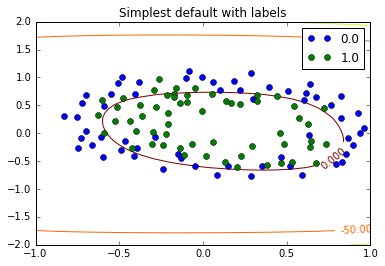

In [73]:
XP_train = generatePolynomials(6, X_train)
XP_test = generatePolynomials(6, X_test)

#print(XP_train)
print(XP_train.shape)

lr.fit(XP_train,y_train)
lr.get_params()

print('Coeff = {}, intercept = {}'.format(lr.coef_, lr.intercept_ ))

print('Score on training set : ', lr.score(XP_train,y_train))
print('Score on test set : ', lr.score(XP_test,y_test))

def plotDecisionBoundaryPoly(lr):
    
    h = .02
    x_min, x_max = XP_train[:, 0].min() - 1, XP_train[:, 0].max() + 1
    y_min, y_max = XP_train[:, 1].min() - 1, XP_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)


def plotDecisionBoundaryPoly2(lr):
    u = np.linspace(-2, 2, 50)
    v = np.linspace(-2, 2, 50)
    
    z = np.zeros((len(u), len(v)))
    
    # for each tuple, evaluate z (after generating polynomials)
    for i in range (len(u)):
        for j in range (len(v)):
            x = np.array([ u[i], v[j]]).reshape(1,2)
            #print('u,v = ',x)
            
            temp = generatePolynomials(6, x)
            #print('poly uv = ', temp)
            zt = np.dot(temp,lr.coef_.transpose()) + lr.intercept_
            #print('z', zt)
            z[i,j] = zt
    print(z)
    cs = plt.contour(u, v, z)
    plt.clabel(cs, inline=1, fontsize=10)
    plt.title('Simplest default with labels')
        
plt.xlim(-1,1)
plt.ylim(-2,2)
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
plotDecisionBoundaryPoly2(lr)  
plt.legend()
plt.show()

In [75]:
x = np.array([ -0.5, 1]).reshape(1,2)
temp = generatePolynomials(6, x)
zt = np.dot(temp,lr.coef_.transpose()) + lr.intercept_
print(zt)
x = np.array([ 0, 0.5]).reshape(1,2)
temp = generatePolynomials(6, x)
zt = np.dot(temp,lr.coef_.transpose()) + lr.intercept_
print(zt)


[[-2.06155594]]
[[ 1.31135809]]
